In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder


# Untuk membuat Silhouette Plot
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples

from feature_engine.outliers import Winsorizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('ecommerce_data_cleaned1.csv')

In [3]:
df.head()

,order_id,order_date,ship_date,aging,ship_mode,product_category,product,sales,quantity,discount,profit,shipping_cost,order_priority,customer_id,customer_name,city,state,country,region,months
0,AU-2015-1,2015-11-09,2015-11-17,8,First Class,Auto & Accessories,Car Media Players,140,2,5,46,4,Medium,LS-001,Lane Daniels,Brisbane,Queensland,Australia,Oceania,Nov
1,AU-2015-2,2015-06-30,2015-07-02,2,First Class,Auto & Accessories,Car Speakers,211,3,3,112,11,Medium,IZ-002,Alvarado Kriz,Berlin,Berlin,Germany,Central,Jun
2,AU-2015-3,2015-12-05,2015-12-13,8,First Class,Auto & Accessories,Car Body Covers,117,5,1,31,3,Critical,EN-003,Moon Weien,Porirua,Wellington,New Zealand,Oceania,Dec
3,AU-2015-4,2015-05-09,2015-05-16,7,First Class,Auto & Accessories,Car & Bike Care,118,2,5,26,2,High,AN-004,Sanchez Bergman,Kabul,Kabul,Afghanistan,Central Asia,May
4,AU-2015-5,2015-07-09,2015-07-18,9,First Class,Auto & Accessories,Tyre,250,1,4,160,16,Critical,ON-005,Rowe Jackson,Townsville,Queensland,Australia,Oceania,Jul


In [4]:
df.columns

Index(['order_id', 'order_date', 'ship_date', 'aging', 'ship_mode',
       'product_category', 'product', 'sales', 'quantity', 'discount',
       'profit', 'shipping_cost', 'order_priority', 'customer_id',
       'customer_name', 'city', 'state', 'country', 'region', 'months'],
      dtype='object')

In [5]:
df['id_name'] = df.groupby('customer_name')['customer_id'].transform('first')


In [6]:
LE=LabelEncoder()
df['id_name'] = LE.fit_transform(df['customer_name'])

In [7]:
df['id_name'].dtypes

dtype('int32')

In [8]:
import pandas as pd
from datetime import datetime

# Baca data Anda ke dalam DataFrame (asumsikan data sudah dibaca)
# df = pd.read_csv('nama_file.csv')

# Ubah kolom 'ship_date' menjadi tipe datetime jika belum
df['ship_date'] = pd.to_datetime(df['ship_date'])

# Hitung tanggal terakhir dalam data
last_date = df['ship_date'].max()

# Kelompokkan data berdasarkan 'customer_id' dan hitung recency
recency_data = df.groupby('id_name')['ship_date'].max().reset_index()
recency_data['recency'] = (last_date - recency_data['ship_date']).dt.days

# Hasil recency_data akan berisi 'customer_id' dan 'recency' untuk setiap pelanggan


In [9]:
import datetime as dt
NOW = dt.date(2016,1,31) 

In [10]:
df['date'] = pd.DatetimeIndex(df.ship_date).date

In [11]:
df_recency = df.groupby(['id_name'],as_index=False)['date'].max()
df_recency.columns = ['id_name','last_date']

In [12]:
df_recency['Recency'] = df_recency.last_date.apply(lambda x:(NOW - x).days)

In [13]:
df_recency['Recency'].max()

69

In [14]:
df_recency.drop(columns=['last_date'],inplace=True)

In [15]:
# Grouping by 'customer_name' and aggregating based on 'order_id' and 'sales'
FM_Table = df.groupby('id_name').agg({'order_id'   : lambda x: len(x),
                                            'sales'      : lambda x: x.sum()})

# Renaming the columns
FM_Table.rename(columns = {'order_id' :'Frequency',
                           'sales'    :'Monetary_Value'}, inplace=True)

# Displaying the first few rows of the modified table
FM_Table.head()


,Frequency,Monetary_Value
id_name,,
0,63,10106
1,62,10350
2,35,4742
3,81,12284
4,75,10943


In [16]:
RFM_Table = df_recency.merge(FM_Table,left_on='id_name',right_on='id_name')
RFM_Table.head()

,id_name,Recency,Frequency,Monetary_Value
0,0,33,63,10106
1,1,35,62,10350
2,2,28,35,4742
3,3,28,81,12284
4,4,34,75,10943


In [17]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [18]:
segmented_rfm = RFM_Table.copy()


In [19]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [20]:
segmented_rfm['R_Score'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_Score'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_Score'] = segmented_rfm['Monetary_Value'].apply(FMScore, args=('Monetary_Value',quantiles))
segmented_rfm.head()

,id_name,Recency,Frequency,Monetary_Value,R_Score,F_Score,M_Score
0,0,33,63,10106,3,3,2
1,1,35,62,10350,4,3,2
2,2,28,35,4742,2,4,4
3,3,28,81,12284,2,1,1
4,4,34,75,10943,4,1,2


In [21]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_Score','F_Score','M_Score']].sum(axis=1)
segmented_rfm.head()

,id_name,Recency,Frequency,Monetary_Value,R_Score,F_Score,M_Score,RFM_Score
0,0,33,63,10106,3,3,2,8
1,1,35,62,10350,4,3,2,9
2,2,28,35,4742,2,4,4,10
3,3,28,81,12284,2,1,1,4
4,4,34,75,10943,4,1,2,7


In [22]:
segmented_rfm['RFM_Score'].nunique()

10

In [23]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Value': ['mean', 'count'] }).round(1)

Recency Frequency Monetary_Value      
             mean      mean           mean count
RFM_Score                                       
3            24.0      84.0        13260.2    65
4            27.1      80.8        12682.8    54
5            27.8      75.0        11935.4    91
6            30.6      72.7        11497.0    84
7            28.5      65.7        10166.6   104
8            30.5      62.3         9667.6   111
9            29.3      54.3         8497.7    84
10           33.7      53.4         8265.7    87
11           34.5      49.1         7587.0    65
12           40.2      47.5         7313.6    50

In [24]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.4689482614620326, : SkewtestResult(statistic=12.868197515954952, pvalue=6.796985076152687e-38)
Frequency's: Skew: 0.19539263075835553, : SkewtestResult(statistic=2.2493355333480984, pvalue=0.024491156733591073)


Monetary_Value's: Skew: 0.23975042009678246, : SkewtestResult(statistic=2.747680114354591, pvalue=0.006001853354976952)


<function matplotlib.pyplot.show(close=None, block=None)>

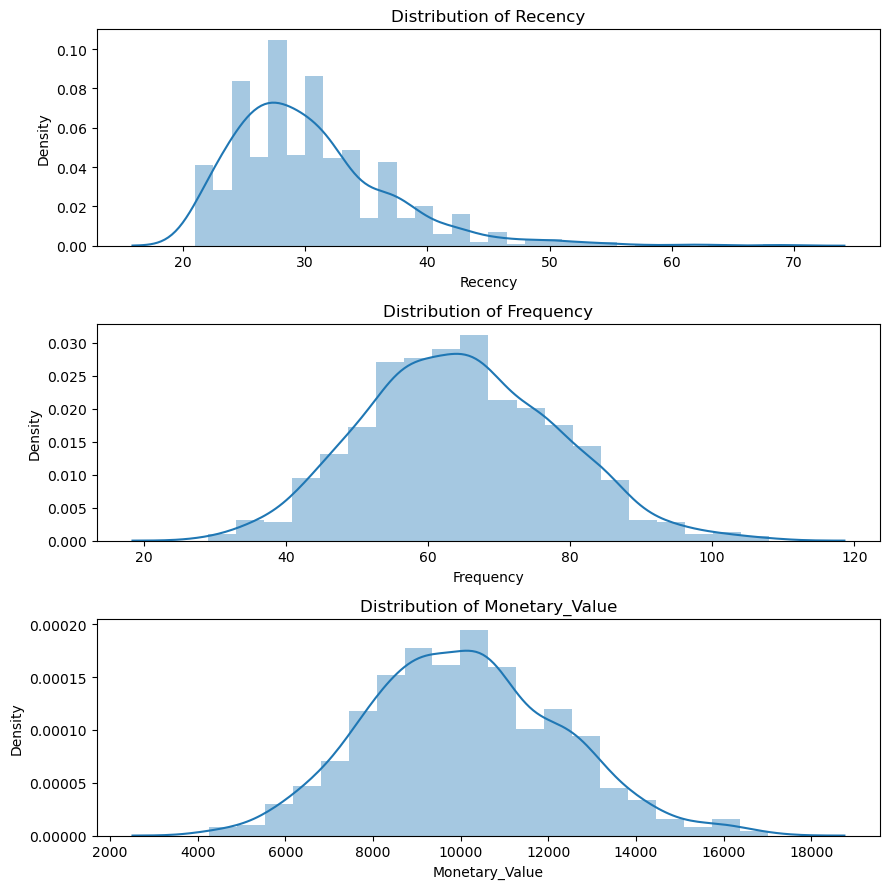

In [25]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary_Value')

plt.tight_layout()
plt.show

In [26]:
df_rfm_log = RFM_Table.copy()

Recency's: Skew: 0.7239298911102037, : SkewtestResult(statistic=7.59562362513789, pvalue=3.063136379633349e-14)


<function matplotlib.pyplot.show(close=None, block=None)>

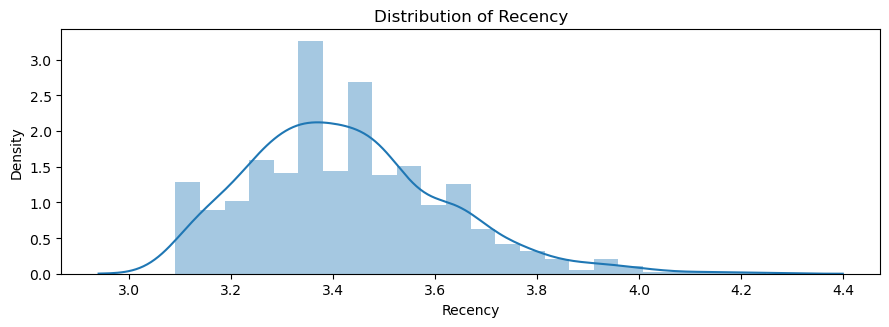

In [27]:
df_rfm_log = np.log(df_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.tight_layout()
plt.show

In [28]:
RFM_Table.describe()


,id_name,Recency,Frequency,Monetary_Value
count,795.000000,795.000000,795.000000,795.000000
mean,397.000000,30.339623,64.496855,10089.115723
std,229.641024,6.490480,13.437641,2203.510532
min,0.000000,21.000000,29.000000,4249.000000
25%,198.500000,26.000000,55.000000,8554.500000
50%,397.000000,29.000000,64.000000,10006.000000
75%,595.500000,33.000000,74.000000,11552.500000
max,794.000000,69.000000,108.000000,17015.000000


In [29]:
from feature_engine.outliers import Winsorizer

# Instantiate the Winsorizer
windsoriser = Winsorizer(capping_method='iqr', 
                         tail='both', # cap left, right or both tails 
                         fold=2,
                         variables=['Recency']
                        )

# Fit the Winsorizer to the data
windsorised_data = windsoriser.fit_transform(df_rfm_log)


In [30]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [31]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)


In [32]:
RFM_Table_scaled

,id_name,Recency,Frequency,Monetary_Value
0,-5.786840,0.527306,-0.006491,0.116830
1,-5.081114,0.827129,-0.080985,0.222506
2,-4.668291,-0.307063,-2.728124,-3.234676
3,-4.375389,-0.307063,1.165843,0.981336
4,-4.148196,0.679359,0.806409,0.469290
...,...,...,...,...
790,1.007558,-1.522971,-0.080985,-0.162210
791,1.008844,-0.681899,1.279831,1.222729
792,1.010129,1.879741,0.417400,0.284131
793,1.011412,-0.307063,-0.156671,-0.230418


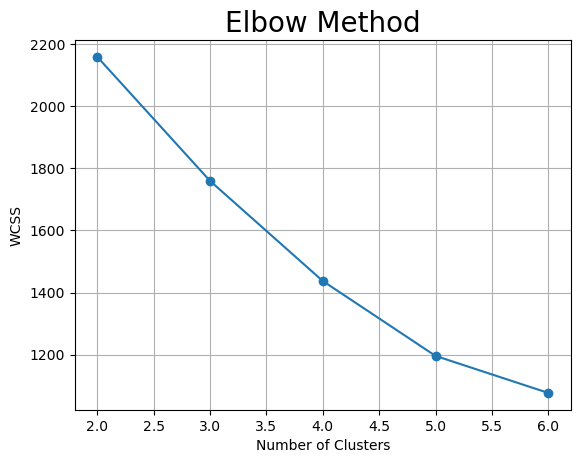

In [33]:
# Membuat grafik elbow metode untuk melihat nilai k terbaik menurut metode elbow

wcss = []
random_state = 10
max_cluster = 6
for i in range(2, max_cluster+1):
# Model definition
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
# Model training
    km.fit(RFM_Table_scaled)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_silhouette(range_n_clusters, X, random_state):
    X_values = X.values if isinstance(X, pd.DataFrame) else X  # Convert to numpy array if X is a DataFrame
    
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X_values) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=random_state)
        cluster_labels = clusterer.fit_predict(X_values)

        silhouette_avg = silhouette_score(X_values, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X_values, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X_values[:, 0], X_values[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
        plt.show()  # Ensure plots are shown

# Placeholder for testing the function (comment this out when integrating with your actual data)
# plot_silhouette(range(2, 6), pd.DataFrame(np.random.rand(100, 2)), 10)


For n_clusters = 2 The average silhouette_score is : 0.29739937623741053


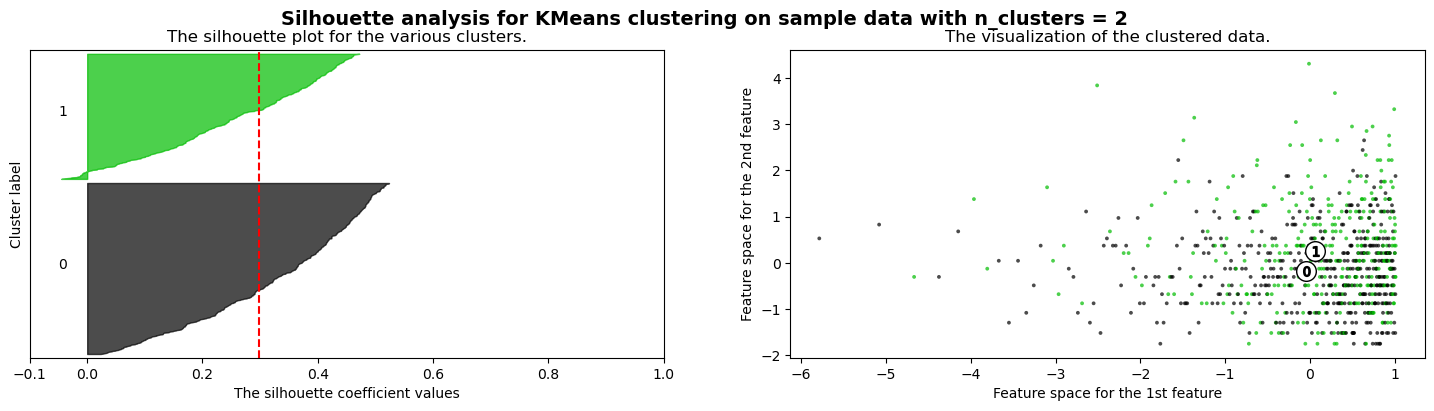

For n_clusters = 3 The average silhouette_score is : 0.2986697408864892


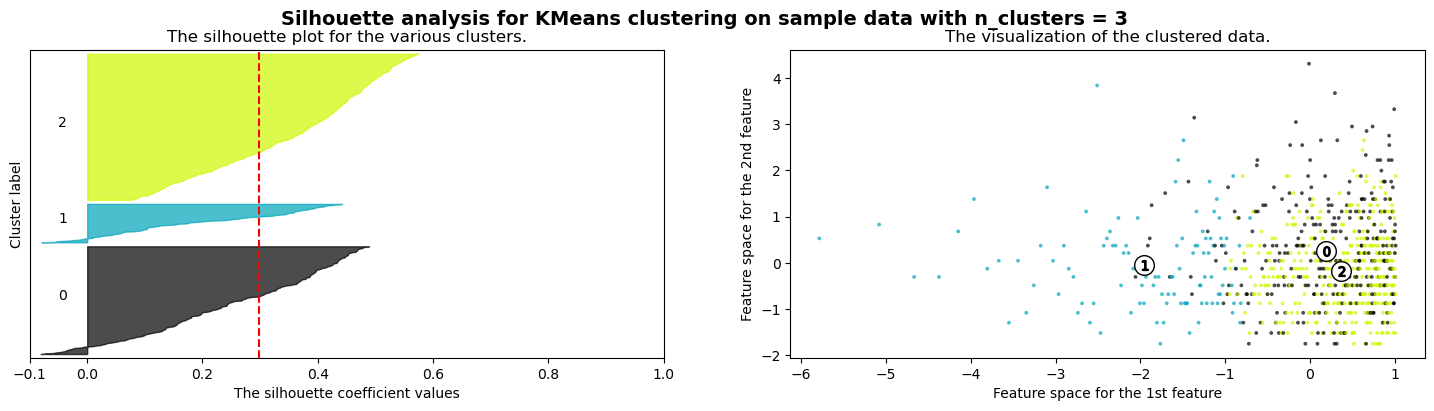

For n_clusters = 4 The average silhouette_score is : 0.28926461174302626


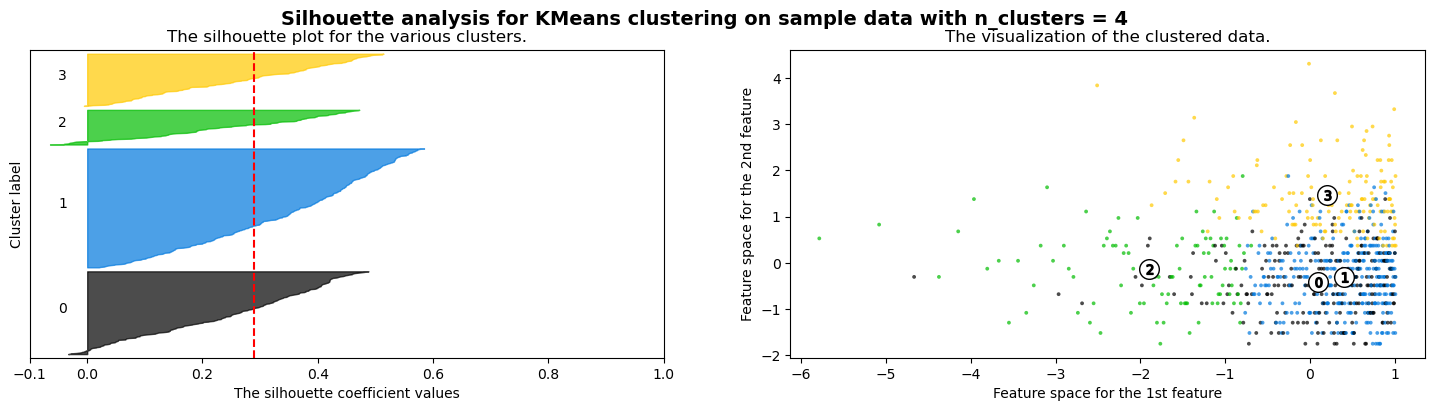

For n_clusters = 5 The average silhouette_score is : 0.2740423411463648


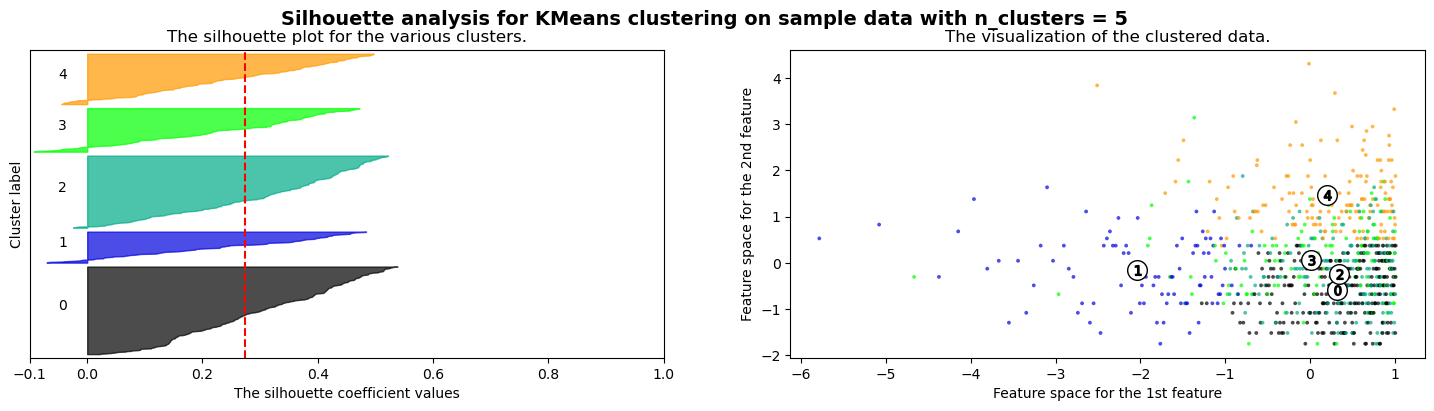

In [35]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), RFM_Table_scaled, random_state)

In [36]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

<function matplotlib.pyplot.show(close=None, block=None)>

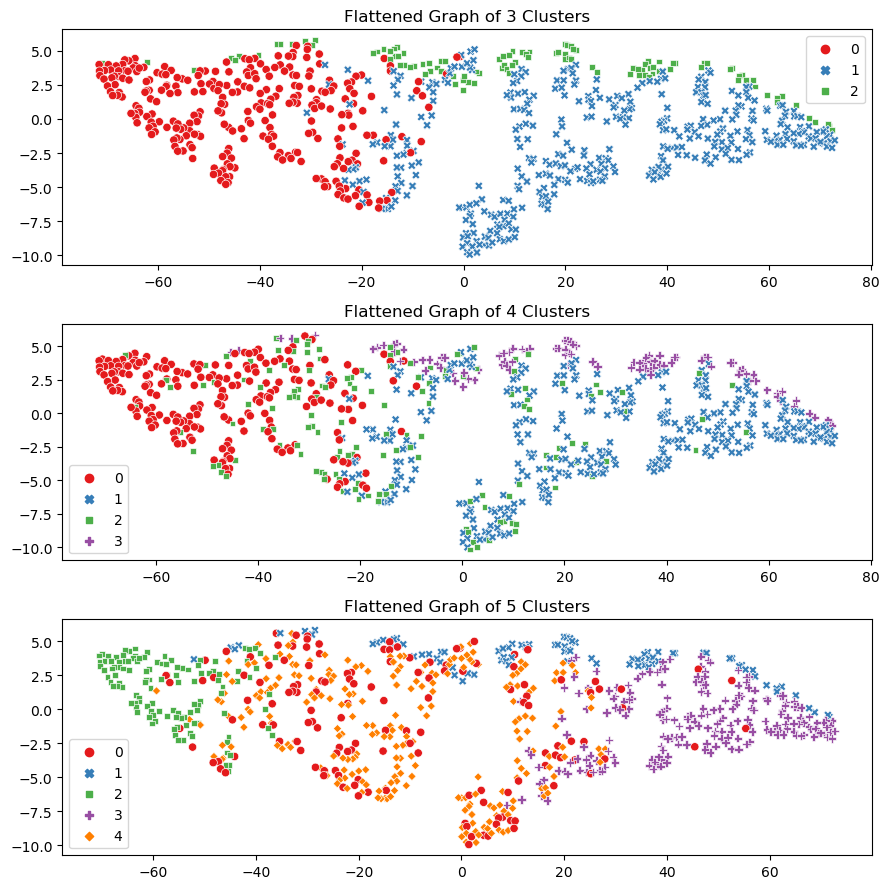

In [37]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()
plt.show

In [38]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['id_name', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary_Value'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')

    return    

<function matplotlib.pyplot.show(close=None, block=None)>

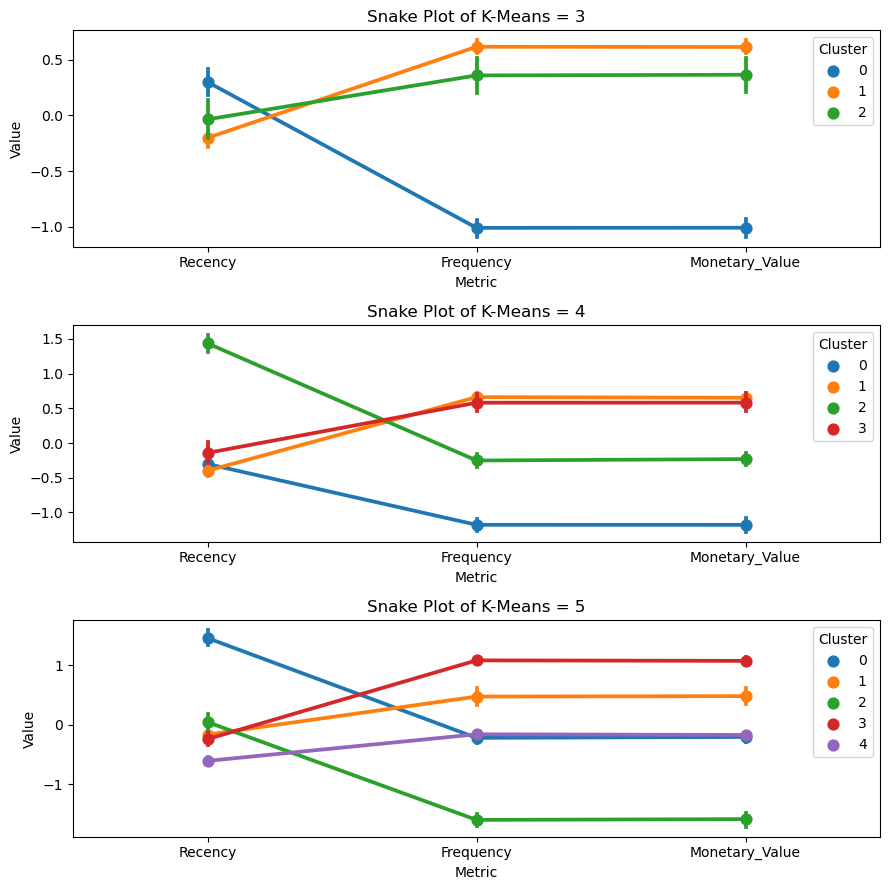

In [39]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()
plt.show

In [40]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary_Value': ['mean', 'count']
    }).round(0)
    
    return df_new

In [41]:
rfm_values(df_rfm_k3)

Recency Frequency Monetary_Value      
           mean      mean           mean count
Cluster                                       
0          32.0      51.0         7925.0   284
1          29.0      73.0        11410.0   402
2          30.0      69.0        10856.0   109

# Conclusion

1. Cluster 0 - "Consistent Shoppers"

Karakteristik: Kelompok pelanggan ini dicirikan oleh kombinasi yang seimbang antara keterkinian, frequency, dan nilai moneter. Mereka berbelanja secara konsisten dan memiliki jumlah pembelanjaan yang layak, mewakili pelanggan yang dapat diandalkan dan tetap.

- Recency: 30 hari
- frequency: 69 kali
- monetary: $10,809

2. Cluster 1 - "High-Value Champions"

Karakteristik: Cluster ini mewakili pelanggan tingkat atas. Mereka paling sering berbelanja dan juga membelanjakan uang paling banyak, menjadikan mereka juara dalam hal nilai bagi bisnis.

- Recency: 29 hari
- frequency: 73 kali
- monetary: $11,468

3. Cluster 2 - "Occasional Spenders"

Karakteristik: Pelanggan dalam cluster ini lebih jarang berbelanja dan memiliki rata-rata pembelanjaan terendah. Mereka mewakili pembeli sesekali atau lebih konservatif yang mungkin memerlukan insentif atau keterlibatan tambahan untuk meningkatkan frequency belanja dan pembelanjaan mereka.

- Recency: 32 hari
- frequency: 51 kali
- monetary: $7,965


Insight Bisnis:

- Pembeli yang Konsisten: Cluster ini terdiri dari pelanggan yang berbelanja dengan konsistensi yang baik. Meskipun mereka mungkin tidak membelanjakan sebanyak cluster lainnya, keberlanjutan dan keandalan mereka membuat mereka menjadi aset berharga bagi bisnis.

- Juara Bernilai Tinggi: Ini adalah pelanggan paling berharga bagi bisnis. Mereka tidak hanya berbelanja dengan frequency yang tinggi, tetapi mereka juga membelanjakan jumlah uang yang paling banyak. Mereka mewakili segmen pelanggan yang paling loyal dan berharga.

- Pembelanja Sesekali: Meskipun cluster ini berbelanja lebih jarang dan membelanjakan lebih sedikit dibandingkan dengan cluster lain, mereka tetap menawarkan potensi yang belum dimanfaatkan. Mungkin ada alasan tertentu mengapa mereka belum berbelanja lebih sering atau membelanjakan lebih banyak.

Rekomendasi Bisnis:

1. Pembeli yang Konsisten:

    - Penghargaan Loyalitas: Pertimbangkan untuk memberi mereka program loyalitas atau penawaran khusus untuk mengakui dan menghargai keberlanjutan mereka.
    - Promosi Personalisasi: Gunakan data pembelian sebelumnya untuk menawarkan promosi yang disesuaikan dengan minat dan kebiasaan mereka.

2. Juara Bernilai Tinggi:

    - Tawaran Eksklusif: Pertimbangkan untuk memberikan tawaran eksklusif atau akses dini ke produk baru sebagai tanda penghargaan atas loyalitas mereka.
    - Feedback: Minta feedback mereka tentang bagaimana Anda dapat meningkatkan layanan atau produk Anda. Mereka adalah pelanggan yang paling berharga, jadi pemikiran dan pendapat mereka sangat berharga.

3. Pembelanja Sesekali:

    - Keterlibatan Ulang: Luncurkan kampanye pemasaran yang ditargetkan untuk mengajak mereka kembali berbelanja, mungkin dengan menawarkan diskon atau promosi khusus.
    - Pahami Alasannya: Lakukan survei atau minta feedback untuk memahami mengapa mereka berbelanja lebih jarang. Mungkin ada hambatan atau kekhawatiran yang dapat Anda atasi.